# QUED: QUantum Electronic Descriptor

This notebook provides a step-by-step demonstration of the QUED workflow,
covering the entire process from molecular input to descriptor generation:

1. Molecular input via SMILES strings  
2. Conformer generation using CREST  
3. Quantum-mechanical property calculation with DFTB+  
4. Construction of quantum-mechanical (QM) descriptors  

For generating a complete ML-ready dataset, users are referred to the `smile2dataset.py` script included in the QUED repository.

**Scope:** Tutorial and reproducible example for a small-scale demonstration  

**Dataset:** The notebook uses the toxicity database configuration provided within QUED  

**Not included:** Full-scale ML training, hyperparameter optimization, or large datasets  

**Resources:**  

[QUED GitHub repository](https://github.com/lmedranos/QUED.git)

[QUED preprint](https://doi.org/10.26434/chemrxiv-2025-hj4dc)

## Environment & Requirements

We assume that the Python environment has been created following the instructions provided in the [QUED GitHub repository](https://github.com/lmedranos/QUED.git), ensuring compatibility with the modules of QUED and its external dependencies used in this work.

All required Python modules are imported, including numerical and scientific libraries, machine-learning utilities, and the core QUED modules for molecular geometry generation, electronic-structure calculations, and descriptor handling. 

**Requirements:**
- Python 3.9
- numpy, matplotlib, scikit-learn
- ase, rdkit
- h5py
- qml, crest, dftb+
- xgboost, optuna, shap

Run this notebook in the same directory where the `qued` directory is located.
> The environment variables `DFTB_COMMAND` and `DFTB_PREFIX` must be explicitly defined. `DFTB_COMMAND` specifies the command used to launch DFTB+. `DFTB_PREFIX` points to the directory containing the Slater–Koster parameter files (e.g., the 3ob-3-1 set) required for DFTB+ calculations. These variables must be correctly set for the quantum-mechanical steps of the QUED workflow to execute successfully.

In [ ]:
# load libraries
import os
import time
import shutil
import subprocess

import h5py
import pickle
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import shap

from qued.smile2geom import generate_xyz_from_smiles
from qued.electronic import get_atomic_numbers_n_coordinates, calculate_dftb_props, pad_charges
from qued.electronic import qm_props_names
from qued.geometric import tox_database_config
configuration = tox_database_config

# specify explicit environment variables
os.environ["DFTB_COMMAND"] = "mpiexec -n 1 /path/to/dftb+/qued/bin/dftb+"
os.environ["DFTB_PREFIX"] = "/path/to/slater-koster-files/3ob-3-1/"

## Input data & Molecular Representation

### 1. Generation of an initial molecular geometry from SMILES

In this step, the molecular input is provided as a SMILES string, which serves as a compact and unambiguous representation of the molecular connectivity. As an example, we consider `O=C(O)CS`.

The SMILES string is converted into an initial three-dimensional molecular geometry using RDKit. Hydrogen atoms are explicitly added to the molecular graph, after which a 3D embedding is generated and locally optimized using the MMFF force field. This procedure yields a reasonable starting geometry that is suitable for subsequent conformational sampling and quantum-mechanical calculations.

The resulting structure is written to an XYZ file (`initial.xyz`), which is the input format expected by the downstream stages of the QUED workflow. 

In [2]:
# Acetic acid, mercapto-
smile = 'O=C(O)CS'
ifilexyz = './initial.xyz'
created, n_heavy, n_total = generate_xyz_from_smiles(smile, ifilexyz)
print(f"SMILE          : {smile}")
print(f"Molecular size : {n_total}")

SMILE          : O=C(O)CS
Molecular size : 9


### 2. Conformational search using CREST

Starting from the initial geometry (`initial.xyz`) generated from the SMILES representation, an extensive conformational search is performed using the CREST program. CREST is employed to explore the low-energy regions of the molecular potential energy surface in an automated and systematic manner, which is essential for obtaining representative molecular structures
for downstream quantum-mechanical property calculations.

In this example, the conformational sampling is carried out at the GFN2-xTB level of theory, including implicit solvation via the GBSA model for water. The search is guided by an energy window threshold, ensuring that only conformers within a specified energy range relative to the minimum are retained. Additional options control the sampling strategy, refinement steps, and computational performance, including the number of threads used during the search.

Upon completion, the generated conformers are collected into a single XYZ file (`conformers.xyz`), which serves as the structural input for subsequent
quantum-mechanical calculations. 

> The specific CREST parameters used here are chosen for demonstration purposes and can be adjusted depending on molecular size, flexibility, and available computational resources.

CREST produces multiple auxiliary output files during the conformational search. For clarity, all CREST-generated files are collected into a
dedicated output directory (`out/`), which keeps the working directory organized.

In [3]:
# auxiliar function to keep everything clean
def move_crest_files():
    outdir = "out"
    os.makedirs(outdir, exist_ok=True)
    # List of files to move (CREST outputs)
    crest_files = [
        f for f in os.listdir(".")
        if f.startswith("crest") or f in {
            "cre_members", "ensemble_energies.log", "gfnff_adjacency", "gfnff_topo", "wbo", "coord", "charges", "xtbopt.xyz", "xtbtopo.mol"
        }
    ]

    for fname in crest_files:
        if os.path.isfile(fname):
            shutil.move(fname, os.path.join(outdir, fname))

In [ ]:
# arguments of CREST (optionally: can be modified)
crest_options = "-gfn2 -gbsa h2o -mrest 5 -rthr 0.1 -ewin 12.0 -mquick -norotmd"
cfilexyz = './conformers.xyz'
# run crest
start = time.time()
result = subprocess.run(["crest", ifilexyz, crest_options], capture_output=True, text=True, check=True)
end = time.time()
elapsed = time.strftime("%H:%M:%S", time.gmtime(end - start))
os.rename('crest_conformers.xyz', cfilexyz)
# count conformers
with open(cfilexyz, 'r') as f:
    lines = f.readlines()
    n_conformers = lines.count(lines[0])
print(f'Conformers generated: {n_conformers}. Time: {elapsed}')
move_crest_files()

Conformers generated: 1. Time: 00:00:48


### 3. Quantum-mechanical property calculation using DFTB+

In this step, electronic-structure properties are computed for a selected molecular conformer using the Density Functional Tight Binding (DFTB+) method. From the ensemble of conformers generated by CREST, a single conformer is selected by index and its atomic numbers and Cartesian coordinates are extracted from the XYZ file.

DFTB+ is executed as an external program, using the Slater–Koster parameter
set specified during environment setup. 

A set of electronic properties is extracted from the DFTB+ output, including energetic contributions (e.g., band energy, repulsion energy, and self-consistent charge terms), the Fermi energy, the total number of electrons, and the tight-binding dipole moment. In addition, the molecular orbital energies and atom-resolved Mulliken charges are retrieved, enabling both global and local electronic descriptors to be constructed in subsequent stages of the QUED workflow.

In [5]:
# auxiliar function to keep everything clean
def move_dftbplus_files():
    outdir = "out"
    os.makedirs(outdir, exist_ok=True)
    # List of files to move (CREST outputs)
    crest_files = [
        f for f in os.listdir(".")
        if f.startswith("dftb_") or f in {
            "band.out", "charges.bin", "current_dftb.out", "detailed.out", "geo_end.gen"
        }
    ]

    for fname in crest_files:
        if os.path.isfile(fname):
            shutil.move(fname, os.path.join(outdir, fname))

In [15]:
# get atomic coordinates and charges
i = 0    # conformer index for which to compute QM properties
Z_mol, xyz_mol = get_atomic_numbers_n_coordinates(cfilexyz, i)
# run dftb+
start = time.time()
DFTBprops = calculate_dftb_props(Z_mol, xyz_mol)
end = time.time()
elapsed = end - start
print(f"QM properties extracted. Time: {elapsed:.6f} seconds")
print(f"Fermi Energy        : {float(DFTBprops[0])}")
print(f"Band Energy         : {float(DFTBprops[1])}")
print(f"Number of Electrons : {float(DFTBprops[2])}")
print(f"H0 Energy           : {float(DFTBprops[3])}")
print(f"SCC Energy          : {float(DFTBprops[4])}")
print(f"3rd-Order Energy    : {float(DFTBprops[5])}")
print(f"Repulsion Energy    : {float(DFTBprops[6])}")
print(f"Many-body Energy    : {float(DFTBprops[7])}")
print(f"TB Dipole Moment    : {DFTBprops[8:11]}")
nEig = int(DFTBprops[11])    # Number of retrieved orbital energies
print(f"Molecular Orbital Energies :")
print(DFTBprops[12:12+nEig])
print(f"Mulliken Charges :")
print(DFTBprops[12+nEig:])
move_dftbplus_files()
charges = pad_charges(DFTBprops[12+nEig:], configuration['max_atoms'])
descriptor = np.concatenate([DFTBprops[:8],[np.linalg.norm(DFTBprops[8:11])],DFTBprops[12:12+nEig],charges])
print(f"\nQM descriptor dimensions: {descriptor.shape}")

QM properties extracted. Time: 0.078438 seconds
Fermi Energy        : -3.6893573995110778
Band Energy         : -384.490803315597
Number of Electrons : 30.0
H0 Energy           : -385.97180804261177
SCC Energy          : 0.859108048087552
3rd-Order Energy    : -0.08346226252443636
Repulsion Energy    : 4.710589421559241
Many-body Energy    : -0.12054323458667321
TB Dipole Moment    : [ 1.94736135 -1.30732625 -0.00281676]
Molecular Orbital Energies :
[-8.453 -8.181 -7.031 -6.416 -0.962  3.017  6.924  9.738]
Mulliken Charges :
[-0.55509878  0.68443259 -0.49100387 -0.16554501 -0.24663327  0.37649199
  0.09947625  0.09942739  0.19845272]

QM descriptor dimensions: (213,)


### 4. Generation of geometric descriptors

The QUED workflow includes the construction of geometric descriptors that encode the three-dimensional arrangement of atoms and capture structural information. These descriptors are typically computed from the full dataset of conformers and can be high-dimensional, leading to substantial memory usage and computational cost.

For this demonstration notebook, the explicit generation of geometric descriptors is omitted to ensure stability, as kernel crashes may occur due to resource limitations. Instead, we refer users to the `dataset2pred` script provided in the QUED repository, which illustrates how to compute geometric descriptors.

## Validation

To illustrate the validation procedure within the QUED framework, we consider an XGBoost regression model trained on 5k samples for toxicity prediction.

> If the user instead wants to validate the lipophilicity predictive model, change the `dataset_path` and `model_path` variables.


### 1. Extracting properties and generating quantum-mechanical descriptors

In this step, we read a precomputed HDF5 dataset (located in `models/training_sets.xz`) containing stable conformers along with their quantum-mechanical properties and construct a numerical representation suitable for machine learning.

The `prepare_data` function iterates over all molecules and their conformers stored in the HDF5 file. For each conformer, the following information is extracted:

- **Atomic information:** Cartesian coordinates and nuclear charges.
- **Global electronic properties:** Fermi energy, band energy, total number of electrons, H0 energy, SCC energy, third-order energy, repulsion energy, many-body dispersion energy, and the magnitude of the tight-binding dipole moment.
- **Electronic structure properties:** Molecular orbital energies.
- **Atomic properties:** Mulliken charges, padded to a fixed size for uniform representation.
- **Target property:** If available (here, `ld50` or `lipophilicity`).

The properties are concatenated into the $\text{D}_\text{QM}$ descriptor, ready to serve as input (`X`) for regression models, while the associated target property values (`y`) are used for model validation.

In [ ]:
# read HDF5 file and extract properties
def prepare_data(dataset_path, target_property):
    # read file
    dataset = h5py.File(dataset_path, 'r')
    print(f"Reading {dataset_path}")

    # collecting properties
    xyz, Z, target = [], [], []
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11 = \
        [], [], [], [], [], [], [], [], [], [], []
    
    for molid in dataset.keys():
        conformers = dataset.get(molid)
        for confid in conformers.keys():
            properties = conformers.get(confid)
            # coordinates and nuclear charges
            xyz.append(np.array(properties['xyz'][()]))
            Z.append(np.array(properties['Z'][()]))
            # global
            p1.append(float(properties['FermiEne'][()]))
            p2.append(float(properties['BandEne'][()]))
            p3.append(float(properties['NumElec'][()]))
            p4.append(float(properties['h0Ene'][()]))
            p5.append(float(properties['sccEne'][()]))
            p6.append(float(properties['3rdEne'][()]))
            p7.append(float(properties['repEne'][()]))
            p8.append(float(properties['mbdEne'][()]))
            p9.append(np.linalg.norm(properties['TBdip'][()]))
            # electronic
            p10.append(np.array(properties['TBeig'][()]))
            # atomic
            p11.append(np.array(properties['TBchg'][()]))
            # target property (if present in dataset)
            if target_property in properties.keys():
                target.append(float(properties[target_property][()]))
    p11 = [pad_charges(x, configuration['max_atoms']) for x in p11]
    target = np.array(target) if len(target)>0 else np.array([0.0]*len(xyz))
    print(f"Number of conformers in dataset: {len(target)}")

    # standarization of QM properties
    _vars = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11]
    prop_array_list = []
    for var in _vars:
        var2 = np.array(var)
        try:
            __ = var2.shape[1]
        except IndexError:
            var2 = var2.reshape(-1, 1)
        scaler = StandardScaler()
        var3 = scaler.fit_transform(var2)
        prop_array_list.append(var3)

    # generate representation
    print(f"Generating QM descriptor")
    descriptor = np.concatenate(prop_array_list, axis=1)
    print(f"Descriptor dimensions: {descriptor.shape}")

    return descriptor, target

# input dataset
dataset_path = '/path/to/ld50-stable.h5'
X, y = prepare_data(dataset_path, 'ld50')


Reading ./models/ld50-stable.h5
Number of conformers in dataset: 7273
Generating QM descriptor
Descriptor dimensions: (7273, 213)


### 2. Loading the trained XGBoost model and evaluating performance

In this step, we load a pre-trained XGBoost regression model from a serialized pickle file (located in `models` directory) that contains both the trained estimator and the indices of the test set used for validation. 

Predictions are computed for these test samples, and standard regression metrics (Mean Absolute Error: MAE, Root Mean Squared Error: RMSE, Coefficient of Determination: R²) are calculated to assess model performance:

In [3]:
# load model parameters from pickle file
model_path = '/path/to/tox-qm.pkl'
with open(model_path, "rb") as f:
    parameters = pickle.load(f)
trained_model = parameters['estimator']

# validate model
test_idxs = parameters['X_test_idxs']
X_test, y_test = X[test_idxs], y[test_idxs]
y_pred = np.round(trained_model.predict(X_test).flatten(), 3)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae: .3f}")
print(f"RMSE: {rmse: .3f}")
print(f"R2: {r2: .3f}")

MAE:  0.475
RMSE:  0.638
R2:  0.570


### 3. SHAP analysis for feature importance

To interpret the predictions of the trained XGBoost model, we perform a SHAP (SHapley Additive exPlanations) analysis. SHAP values provide a method to quantify the contribution of each input feature to individual predictions, allowing insight into which quantum-mechanical properties most strongly influence the target property.

First, the descriptor matrix `X` is standardized using the same scaler applied during model training to ensure consistency. A `TreeExplainer` is then constructed for the trained XGBoost model, and SHAP values are computed for the entire dataset. The resulting values are visualized using a
beeswarm plot, which ranks features by importance and displays the distribution of their contributions across all samples.

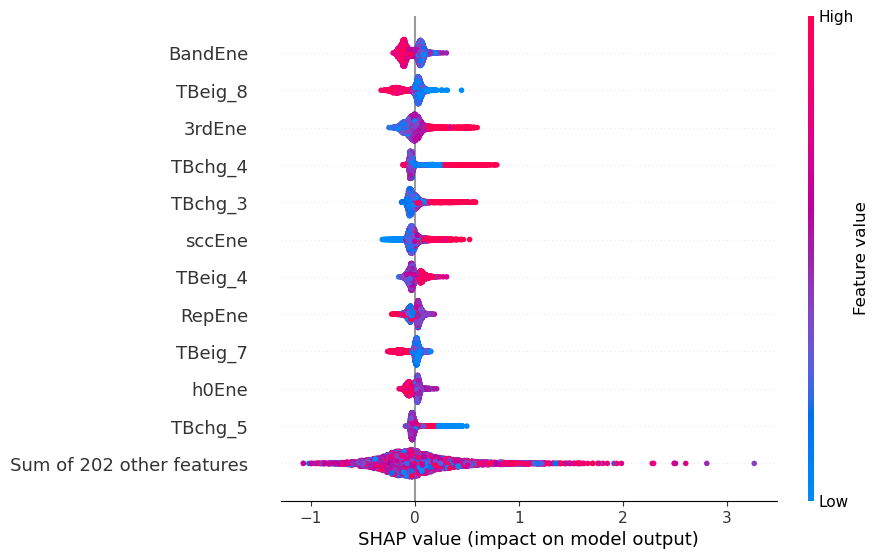

In [4]:
features = qm_props_names[:-2]
features += [f"{qm_props_names[-2]}_{i+1}" for i in range(8)]
features += [f"{qm_props_names[-1]}_{i+1}" for i in range(parameters['max_atoms'])]

# Transform data with the scaler inside the pipeline
X_std = trained_model['scaler'].transform(X)
# SHAP analysis
explainer = shap.TreeExplainer(trained_model['model'], feature_names=features)
# explain the scaled test set
shap_values = explainer(X_std)
# Create the plot
shap.plots.beeswarm(shap_values, max_display=12)